In [1]:
import numpy as np #importing packages
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from dataset_tools import MNIST
from plotting import loss_plots, plot_random_images, plot_image_comparison, plot_latent

from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
flatten = lambda x: ToTensor()(x).view(-1)

# data_train = MNIST(train=True, transform=ToTensor())
# data_test = MNIST(train=False, transform=ToTensor())
data_train = MNIST(train=True, transform=flatten)
data_test = MNIST(train=False, transform=flatten)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4391923.74it/s]


Extracting processed_data/MNIST\raw\train-images-idx3-ubyte.gz to processed_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 219593.13it/s]


Extracting processed_data/MNIST\raw\train-labels-idx1-ubyte.gz to processed_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1877884.90it/s]


Extracting processed_data/MNIST\raw\t10k-images-idx3-ubyte.gz to processed_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2269811.60it/s]

Extracting processed_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to processed_data/MNIST\raw



In [3]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 784]) torch.Size([64])


# VAE

In [4]:
# input img -> hidden -> mu, logvar -> reparameterization trick (sample point from distribution made from mu, logvar) -> decoder -> output img
from models import VAE_MNIST_linear
from loss_functions import loss_function_mean as loss_function


model = VAE_MNIST_linear(input_dim=28*28, hidden_dim=256, latent_dim=2)
print(model)
if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


VAE_MNIST_linear(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=4, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [5]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 784])
x_hat.shape: torch.Size([64, 784])


## Training

In [6]:
num_epochs = 2

train_loss = []
train_mse_loss = []
train_kld_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")




Epoch 1/2, loss: 0.06916549016258863, mse: 0.06916411514125907, kld: 1.3750141311778442e-06
Epoch 2/2, loss: 0.06747204280976675, mse: 0.06747204280976675, kld: 0.0


## Plots

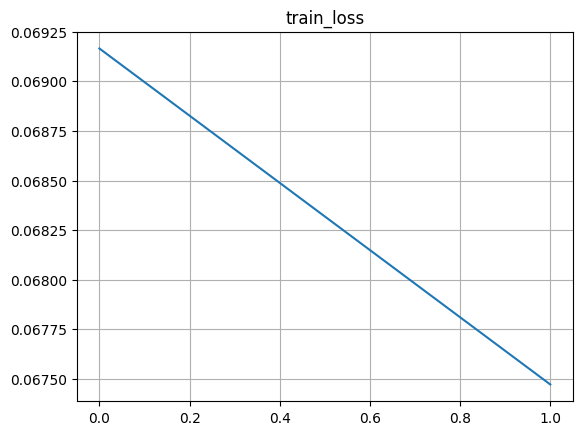

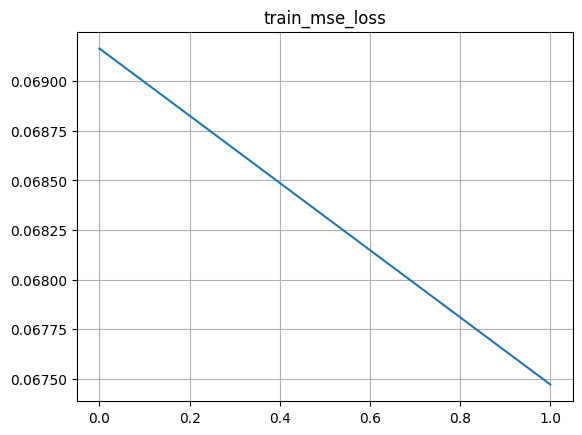

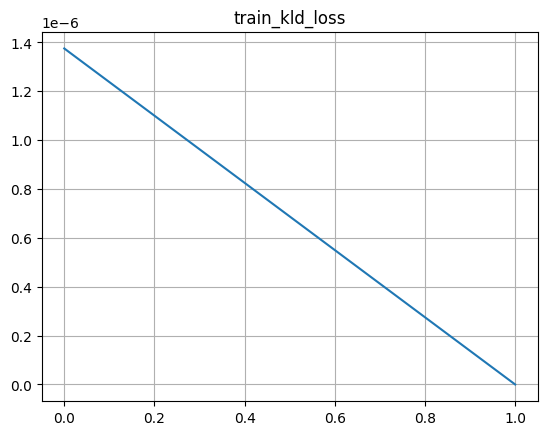

In [7]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss


loss_plots(loss_data, invidual_plots=True)

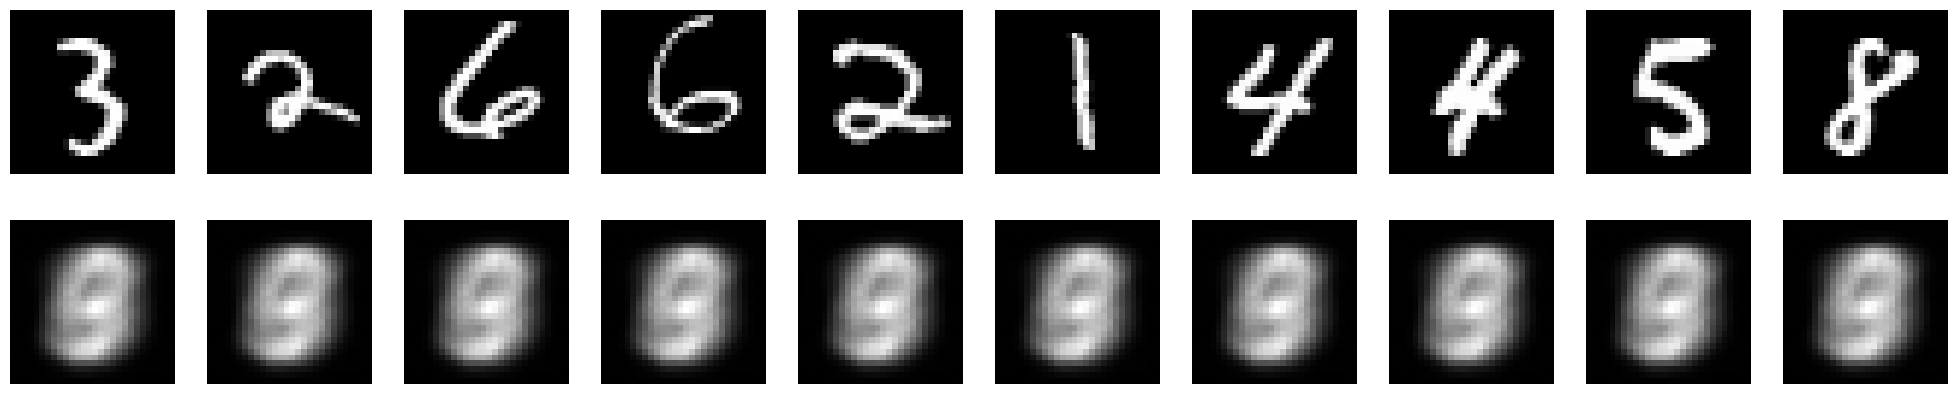

In [8]:
# test the model
plot_image_comparison(model, test_loader, cuda)

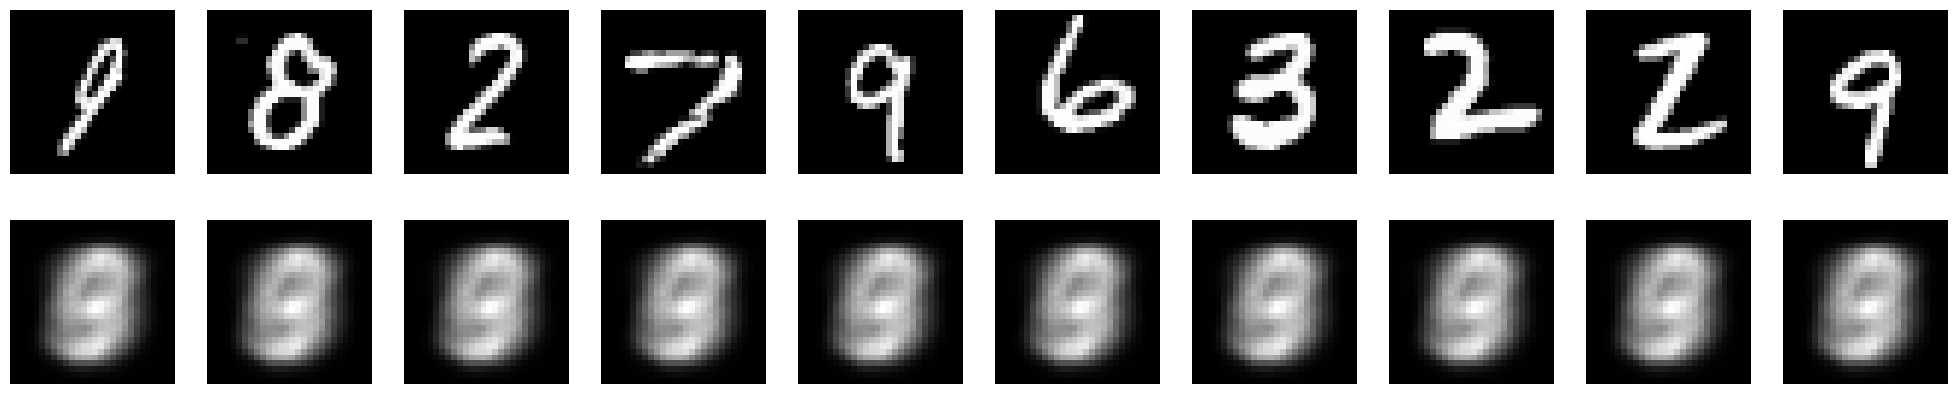

In [9]:
# generate new images using decoder
plot_image_comparison(model, test_loader, cuda)

In [10]:
from inference import Inference

inference = Inference(model, test_loader)

In [11]:
samples = inference.samples

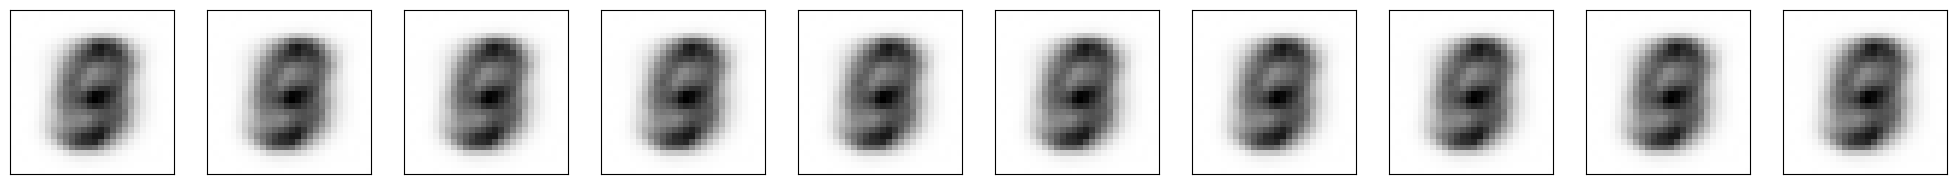

In [12]:


fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for img, ax in zip(samples["5"], axes):
    ax.imshow(img.view(28, 28), cmap='Greys')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)